<a href="https://colab.research.google.com/github/keitake123/LSTM-estimation-modelling/blob/main/estimate_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 機械学習実習

###ドライブに入れた他のファイルを読み込むための処理を行う

<font color= "blue">【▷を押し、Googleドライブへの接続、アカウントの選択と「許可」を行いましょう】</font>

<font color= "blue">＊できないときは、何回か押してみましょう</font>

<font color ="blue">＊成功すると↓のようになります </font>

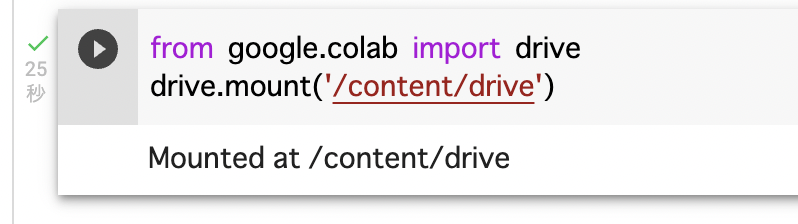



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### プログラムに使う道具をインポート（読み込み）する

<font color= "blue">【▷を押してみましょう】</font>

<font color="blue">＊成功すると✅が出てきます

In [ ]:
import csv
import glob
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import torch.optim as optim
import datetime
import tkinter
import cv2
from PIL import Image, ImageTk
import time
import matplotlib.pyplot as plt

###プログラムで使う道具の準備をする

<font color= "blue">【▷を押してみましょう】</font>

<font color="blue">＊成功すると✅が出てきます</font>

In [ ]:
def twosComplement_hex(hexval):
    bits = 16
    val =hexval
    if val & (1 << (bits-1)):
        val -= 1 << bits
    return val

#int関数の例外処理
def _is_hex(val):
    try:
        x = int(val, 16)
        return True
    except ValueError:
        return False

class LSTM(nn.Module):

    def __init__(self):

        super(LSTM, self).__init__()
        self.seq_len = 200 # XYZ軸を時系列のSequenceとしてLSTMに入力する
        self.feature_size = 3 # 1つの軸当たりの特徴量の次元としてLSTMに入力する
        self.hidden_layer_size = 100 # 隠れ層のサイズ
        self.lstm_layers = 1 # LSTMのレイヤー数　(LSTMを何層重ねるか)
        self.lstm = nn.LSTM(self.feature_size, self.hidden_layer_size, num_layers = self.lstm_layers)
        self.fc = nn.Linear(self.hidden_layer_size, 10)

    def init_hidden_cell(self, batch_size): # LSTMの隠れ層 hidden と記憶セル cell を初期化
        hedden = torch.zeros(self.lstm_layers, batch_size, self.hidden_layer_size, device=x.device)
        cell = torch.zeros(self.lstm_layers, batch_size, self.hidden_layer_size, device=x.device)
        return (hedden, cell)

    def forward(self, x):
        batch_size = 1
        # print(batch_size)

        hedden = torch.zeros(self.lstm_layers, batch_size, self.hidden_layer_size, device=x.device)
        cell = torch.zeros(self.lstm_layers, batch_size, self.hidden_layer_size, device=x.device)
        self.hidden_cell = (hedden, cell)

        # print(x.size())
        x = x.view(batch_size, self.seq_len, self.feature_size)  # (Batch, Cannel, Height, Width) -> (Batch, Height, Width) = (Batch, Seqence, Feature)
                                                                 # 画像の Height を時系列のSequenceに、Width を特徴量の次元としてLSTMに入力する
        # print(x.size())
        x = x.permute(1, 0, 2)                                   # (Batch, Seqence, Feature) -> (Seqence , Batch, Feature)

        lstm_out, (h_n, c_n) = self.lstm(x, self.hidden_cell)    # LSTMの入力データのShapeは(Seqence, Batch, Feature)
                                                                 # (h_n) のShapeは (num_layers, batch, hidden_size)
        x = h_n[-1,:,:]                                          # lstm_layersの最後のレイヤーを取り出す  (B, h)
        x = self.fc(x)

        return x


###作成したLSTMモデルを使うことを指示する

<font color= "blue">【'model.pth'のパスのコピーを行い、コード内の''の中に貼り付けましょう】</font>

＊例：*model_path = '/content/drive/MyDrive/GIYSEdemo/model.pth'*

<font color= "blue">【▷を押してみましょう】</font>

<font color ="blue">＊成功すると✅が出てきます</font>

In [ ]:
model_path = '/content/drive/MyDrive/GIYSEdemo/model.pth'
net = LSTM()
net.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))


<All keys matched successfully>

###テストデータのファイルを指定する

<font color= "blue">【識別をしたいファイルのパスのコピーを行い、コード内の''の中に貼り付けましょう】</font>

例 : test_file = '/content/drive/My Drive/GIYSEdemo/test.csv'

<font color= "blue">✳︎できない場合、ファイル名が正しいかチェックしましょう</font>

<font color= "blue">✳︎テストデータファイルがGIYSEcolabファイルに入っていることを確認しましょう</font>

<font color= "blue">✳︎パスがシングルクォーテーションで挟まれているか確認しましょう</font>

<font color= "blue">【▷を押してみましょう】</font>

<font color ="blue">成功すると✅が出てきます</font>


In [ ]:
test_file = '/content/drive/MyDrive/GIYSEdemo/test.csv'

###テストデータを識別できる形に加工する

<font color= "blue">【▷を押してみましょう】</font>

<font color= "blue">＊成功すると✅が出てきます</font>

In [ ]:
classes = ['すいすい(Wipe)', 'さっさっ(Sweep)', 'ごしごし(Rub)', 'さしこみ(Insert)', 'そのほか(Other)']

test_data = []
test_data.append([[], [], []])

with open(test_file,"r") as f:
    reader = csv.reader(f)
    num_dim = 0
    for row in reader:
        if('nan' in row[2]) or ('nan' in row[3]) or ('nan' in row[4]):
            pass
        elif (num_dim < 200):
            test_data[0][0].append(row[2])  #x軸の加速度データを入れる
            test_data[0][1].append(row[3])  #y軸の加速度データを入れる
            test_data[0][2].append(row[4])  #z軸の加速度データを入れる
            num_dim += 1
        else :
            break


###取得した加速度データを図にする

<font color="blue">【▷を押してみましょう】</font>

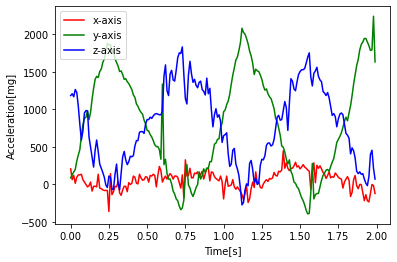

In [ ]:
fig, ax = plt.subplots(1, 1)

x = np.arange(0,2,0.01)

xx = [float(i) for i in test_data[0][0]]
yy = [float(i) for i in test_data[0][1]]
zz = [float(i) for i in test_data[0][2]]
ax.plot(x,xx, label='x-axis', color='red')
ax.plot(x,yy, label='y-axis', color='green')
ax.plot(x,zz, label='z-axis', color='blue')
ax.set_xlabel("Time[s]")
ax.set_ylabel("Acceleration[mg]")
ax.legend()
plt.pause(0.001)
plt.show()

###テストデータをLSTMモデルに入れるために形を整える

<font color= "blue">【▷を押してみましょう】</font>

<font color="blue">＊成功すると✅が出てきます</font>

In [ ]:
test_data = np.array(test_data, dtype=np.int64)
test_data = torch.tensor(test_data, dtype=torch.float32)

###識別を行う

<font color= "blue">【▷を押してみましょう】</font>

<font color="blue">＊成功すると✅が出てきます

In [ ]:
net.eval()
outputs = net(test_data)
_, preds = torch.max(outputs, 1)
print('識別結果 ： ' + classes[preds[0].item()])


識別結果 ： ごしごし(Rub)
